In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [2]:
clf = DecisionTreeClassifier(criterion="gini", max_depth=5)

In [3]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.25, stratify=wine.target)

In [4]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

In [5]:
accuracy_score(y_test, clf.predict(X_test))

0.8666666666666667

In [6]:
f1_score(y_test, clf.predict(X_test), average="weighted")

np.float64(0.866163901458019)

In [7]:
roc_auc_score(y_test, clf.predict_proba(X_test), multi_class="ovo")

np.float64(0.9069444444444444)

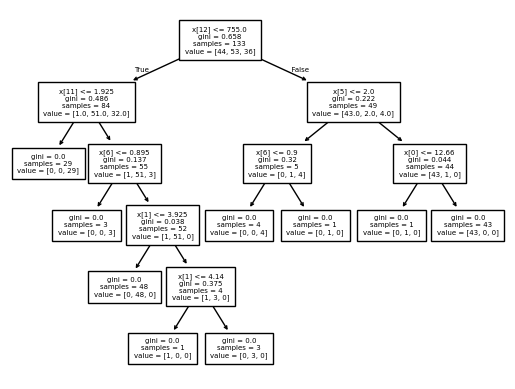

In [30]:
plot_tree(clf, fontsize=5);

### Реализация дерева решений

In [8]:
class MyDecisionTree:
    LEAF = 1
    NON_LEAF = 0

    def __init__(self, max_depth=5, criterion="gini", min_samples_split=2) -> None:
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criterion = criterion
        self.tree = dict()
        self.num_classes = -1
        self.feature_importance = None
        pass

    def fit(self, X_train, y_train):
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        self.feature_importance = np.zeros(X_train.shape[1])
        self.num_classes = np.unique(y_train).shape[0]
        self.fit_node(X_train, y_train, 0, 0)

    def _entropy(self, y):
        p = np.bincount(y) / len(y)
        p = p[np.where(p > 0)[0]]
        return -np.sum(p * np.log(p))

    def _gini(self, y):
        p = np.bincount(y) / len(y)
        return np.sum(p * (1 - p))

    def get_entropy_score(self, y_left, y_right):
        Hs = []
        for split in (y_left, y_right):
            H = self._entropy(split)
            R = len(split) / (len(y_left) + len(y_right))
            Hs.append(R * H)
        return np.sum(Hs)

    def get_gini_score(self, y_left, y_right):
        Hs = []
        for split in (y_left, y_right):
            H = self._gini(split)
            R = len(split) / (len(y_left) + len(y_right))
            Hs.append(R * H)
        return np.sum(Hs)

    def find_threshold(self, X, y: np.ndarray):

        min_criterion = np.inf
        feature_split = -1
        threshold_split = -1

        if self.criterion == "gini":
            H = self._gini(y)
            criterion = self.get_gini_score
        elif self.criterion == "entropy":
            H = self._entropy(y)
            criterion = self.get_entropy_score
        else:
            raise RuntimeError("invalid criterion type")

        for feat in range(X.shape[1]):
            column = X[:, feat]
            unique_values = np.unique(column)
            for value in unique_values:
                left_mask = column <= value
                right_mask = column > value
                y_left = y[left_mask]
                y_right = y[right_mask]
                current_criterion = criterion(y_left, y_right)
                if current_criterion < min_criterion:
                    feature_split = feat
                    threshold_split = value
                    min_criterion = current_criterion

        information_gain = H - min_criterion
        self.feature_importance[feature_split] += information_gain
        return feature_split, threshold_split

    def make_final_leaf(self, y, node_id):
        probs = np.zeros(self.num_classes)
        value, counts = np.unique(y, return_counts=True)
        predict = value[np.argmax(counts)]

        for i in range(len(value)):
            val = value[i]
            probs[val] = counts[i]

        counts = probs
        proba = counts / np.sum(counts)
        self.tree[node_id] = [self.LEAF, predict, proba]

    def fit_node(self, X_train, y_train, node_id, depth):
        if depth == self.max_depth - 1 or X_train.shape[0] == self.min_samples_split:
            self.make_final_leaf(y_train, node_id)
            return

        feature_split, threshold_split = self.find_threshold(X_train, y_train)

        X_left = X_train[X_train[:, feature_split] <= threshold_split]
        y_left = y_train[X_train[:, feature_split] <= threshold_split]
        X_right = X_train[X_train[:, feature_split] > threshold_split]
        y_right = y_train[X_train[:, feature_split] > threshold_split]

        if X_left.shape[0] == 0 or X_right.shape[0] == 0:
            self.make_final_leaf(y_train, node_id)
            return

        self.fit_node(X_left, y_left, 2 * node_id + 1, depth + 1)
        self.fit_node(X_right, y_right, 2 * node_id + 2, depth + 1)

        self.tree[node_id] = [self.NON_LEAF, feature_split, threshold_split]

    def predict_class_one_elem(self, x, node_id):
        if self.tree[node_id][0] == self.LEAF:
            return self.tree[node_id][1:]
        else:
            _, feature, split = self.tree[node_id]
            if x[feature] <= split:
                return self.predict_class_one_elem(x, 2 * node_id + 1)
            else:
                return self.predict_class_one_elem(x, 2 * node_id + 2)

    def predict(self, X):
        return np.array([self.predict_class_one_elem(x, 0)[0] for x in X])

    def predict_proba(self, X):
        return np.array([self.predict_class_one_elem(x, 0)[1] for x in X])

In [9]:
my_tree = MyDecisionTree(max_depth=5, criterion="gini")

In [10]:
my_tree.fit(X_train, y_train)

In [11]:
preds = my_tree.predict(X_test)

In [12]:
accuracy_score(y_test, preds)

0.8444444444444444

In [13]:
pd.DataFrame(
    {
        "columns": wine["feature_names"],
        "my_tree": my_tree.feature_importance,
        "sklearn": clf.feature_importances_,
    }
).sort_values(by="my_tree", ascending=False)

,columns,my_tree,sklearn
11,od280/od315_of_diluted_wines,0.396501,0.380298
1,malic_acid,0.320000,0.022397
12,proline,0.269838,0.409784
5,total_phenols,0.149033,0.083383
6,flavanoids,0.101195,0.081820
0,alcohol,0.053297,0.022318
4,magnesium,0.000000,0.000000
2,ash,0.000000,0.000000
3,alcalinity_of_ash,0.000000,0.000000
8,proanthocyanins,0.000000,0.000000


### Случайный лес

In [14]:
from sklearn.ensemble import RandomForestClassifier

In [15]:
rf = RandomForestClassifier(max_depth=10, criterion="gini", n_estimators=10)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
# accuracy_score(y_test, y_pred)
roc_auc_score(y_test, rf.predict_proba(X_test), multi_class="ovo")

np.float64(0.9956018518518519)

In [16]:
class MyRandomForest:
    def __init__(self, n_estimators=10, *args, max_samples=None):
        self.args = args
        self.n_estimators = n_estimators
        self.estimators = [None] * n_estimators
        self.max_samples = max_samples

    def fit(self, X_train: np.ndarray, y_train):
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        self.estimators = [MyDecisionTree(*self.args) for _ in range(self.n_estimators)]
        self.selected_features = []
        self.feature_importance = np.zeros(X_train.shape[1])
        for estimator in self.estimators:
            if self.max_samples is None:
                size = X_train.shape[0]
            else:
                size = int(self.max_samples * X_train.shape[0])
            ids_sample = np.random.choice(X_train.shape[0], size=size)
            features = np.random.choice(X_train.shape[1], replace=False, size=int(np.sqrt(X_train.shape[1])))
            self.selected_features.append(features)
            estimator.fit(X_train[ids_sample][:, features], y_train[ids_sample])
            self.feature_importance[features] += estimator.feature_importance / self.n_estimators

    def predict_proba(self, X_test):
        return np.array(
            [estimator.predict_proba(X_test[:, sf]) for estimator, sf in zip(self.estimators, self.selected_features)]
        ).mean(axis=0)

In [17]:
my_rf = MyRandomForest()
my_rf.fit(X_train, y_train)

In [18]:
y_test.shape, my_rf.predict_proba(X_test).shape, X_test.shape

((45,), (45, 3), (45, 13))

In [19]:
roc_auc_score(y_test, my_rf.predict_proba(X_test), multi_class="ovo")

np.float64(0.9859567901234568)

In [20]:
pd.DataFrame(
    {
        "columns": wine["feature_names"],
        "my_rf": my_rf.feature_importance,
        "sklearn": rf.feature_importances_,
    }
).sort_values(by="my_rf", ascending=False)

,columns,my_rf,sklearn
1,malic_acid,0.254297,0.020300
2,ash,0.239503,0.024144
11,od280/od315_of_diluted_wines,0.237542,0.087987
5,total_phenols,0.198286,0.026895
9,color_intensity,0.163812,0.126341
4,magnesium,0.096381,0.033126
0,alcohol,0.074034,0.168869
8,proanthocyanins,0.049861,0.002220
10,hue,0.046328,0.088812
7,nonflavanoid_phenols,0.045430,0.007991
